<a href="https://colab.research.google.com/github/ruthetum/Deeplearning-NLP/blob/master/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다층 퍼셉트론(Multilayer Perceptron, MLP)으로 텍스트 분류하기

In [1]:
%tensorflow_version 2.x

import tensorflow as tf

print('version : ', tf.__version__)
print('GPU Available : ', tf.test.is_gpu_available())

version :  2.2.0-rc1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available :  False


In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

t = Tokenizer()
t.fit_on_texts(texts)
print(t.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


# texts_to_metrix에는 4가지 모드가 존재
# 단어 순서는 보존하지 않음

# 1) count : 단어 횟수 그대로

In [3]:
print(t.texts_to_matrix(texts, mode = 'count'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


# 2) binary : 중복은 제외, 단어의 존재 유무만 판단

In [4]:
print(t.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


# 3) tdidf : TF-IDF 행렬 만듦

In [5]:
print(t.texts_to_matrix(texts, mode = 'tfidf').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]


# 4) freq : 각 문서에서 각 단어의 빈도

Ex. 3번째 문장의 '길고 노란 바나나 바나나'

문서의 크기 : 4 , 바나나의 빈도 : 2

-> 0.5

In [6]:
print(t.texts_to_matrix(texts, mode = 'freq').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


# 20개 뉴스 그룹 데이터에 대한 이해

In [7]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# 사이킷런에서 뉴스 그룹 데이터 제공
newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴, all을 넣으면 전체 데이터 다운로드 가능

In [9]:
# 속성 확인
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [10]:
# 우리가 사용할 속성은 data(이메일 본문), target(메일이 어떤 주제인지 적힌 숫자 레이블)
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [11]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [13]:
print('첫번째 샘플의 레이블 : {}\n'.format(newsdata.target[0]))
print('7번 레이블이 의미하는 주제 : {}\n'.format(newsdata.target_names[7]))
print(newsdata.data[0])

첫번째 샘플의 레이블 : 7

7번 레이블이 의미하는 주제 : rec.autos

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







20개의 주제 중 7번 주제

7번에 해당하는 주제는 rec.autos

내용 출력 결과

In [14]:
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
email     11314 non-null object
target    11314 non-null int64
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


In [16]:
# Null 값 찾기
data.isnull().values.any()

False

In [17]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


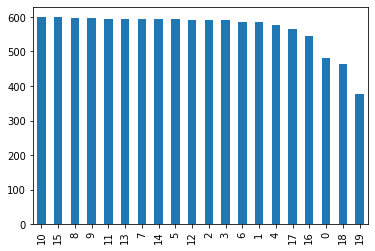

In [18]:
# 데이터 분포 확인
data['target'].value_counts().plot(kind='bar')

In [19]:
# 구체적인 수치 확인
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [0]:
# 본문(email)이랑 레이블(target) 분리하고 테스트 데이터 불러오기

# 'test'를 기재하면 테스트 데이터만 리턴
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)

# 훈련 데이터의 본문 저장
train_email = data['email']
# 훈련 데이터의 레이블 저장
train_label = data['target']

# 테스트 데이터의 본문 저장
test_email = newsdata_test.data
# 테스트 데이터의 레이블 저장
test_label = newsdata_test.target

In [0]:
max_words = 10000 # 실습에 사용할 단어의 최대 개수 -> 9999개 사용, 0은 padding으로 사용해서 1~9999
num_classes = 20 # 레이블의 수

In [0]:
# 전처리 함수
def prepare_data(train_data, test_data, mode):
    t = Tokenizer(num_words = max_words) # max_words 개수만큼의 단어만 사용
    t.fit_on_texts(train_data)
    X_train = t.texts_to_matrix(train_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    X_test = t.texts_to_matrix(test_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    return X_train, X_test, t.index_word

In [0]:
# binary 모드 사용
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary')

y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

In [24]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [25]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(max_words,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

In [27]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)

Epoch 1/5
80/80 [==============================] - 3s 43ms/step - loss: 2.2527 - accuracy: 0.3506 - val_loss: 0.9562 - val_accuracy: 0.8145
Epoch 2/5
80/80 [==============================] - 3s 41ms/step - loss: 0.8513 - accuracy: 0.7735 - val_loss: 0.4620 - val_accuracy: 0.8905
Epoch 3/5
80/80 [==============================] - 3s 41ms/step - loss: 0.4319 - accuracy: 0.8920 - val_loss: 0.3406 - val_accuracy: 0.9143
Epoch 4/5
80/80 [==============================] - 3s 42ms/step - loss: 0.2556 - accuracy: 0.9374 - val_loss: 0.3122 - val_accuracy: 0.9143
Epoch 5/5
80/80 [==============================] - 3s 42ms/step - loss: 0.1737 - accuracy: 0.9573 - val_loss: 0.2953 - val_accuracy: 0.9196
binary 모드의 테스트 정확도: 0.8226234912872314
Epoch 1/5
80/80 [==============================] - 4s 46ms/step - loss: 2.7515 - accuracy: 0.2392 - val_loss: 1.6457 - val_accuracy: 0.7217
Epoch 2/5
80/80 [==============================] - 4s 46ms/step - loss: 1.4708 - accuracy: 0.6194 - val_loss: 0.7345 - va